## LGBM - Google Analytics Customer Revenue Prediction
* Note: this is just a starting point, there's a lot of work to be done.*
* I also have a [deep learning](https://www.kaggle.com/dimitreoliveira/deep-learning-keras-ga-revenue-prediction) version of this code, this one is supposed to be a comparation between the models.
* I'm new to LGBM if you have any tip or correction please let me know.

### Dependencies

In [1]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error

%matplotlib inline
pd.options.display.max_columns = 999

### Auxiliar functions

In [2]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    
    return df

Function to load and convert files borrowed from this [kernel](https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook), thanks!

In [3]:
def load_df(file_name = 'train_v2.csv', nrows = None):
    USE_COLUMNS = [
        'channelGrouping', 'date', 'device', 'fullVisitorId', 'geoNetwork',
        'socialEngagementType', 'totals', 'trafficSource', 'visitId',
        'visitNumber', 'visitStartTime', 'customDimensions']

    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv('../input/{}'.format(file_name),
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, nrows=nrows, usecols=USE_COLUMNS)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    # Normalize customDimensions
    df['customDimensions']=df['customDimensions'].apply(literal_eval)
    df['customDimensions']=df['customDimensions'].str[0]
    df['customDimensions']=df['customDimensions'].apply(lambda x: {'index':np.NaN,'value':np.NaN} if pd.isnull(x) else x)

    column_as_df = json_normalize(df['customDimensions'])
    column_as_df.columns = [f"customDimensions.{subcolumn}" for subcolumn in column_as_df.columns]
    df = df.drop('customDimensions', axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [4]:
train = load_df("../input/train_v2.csv", nrows=1000000)
test = load_df("../input/test_v2.csv", nrows=1000000)

### About the train data

In [5]:
train.head().T

,0,1,2,3,4
channelGrouping,Organic Search,Referral,Direct,Organic Search,Organic Search
date,20171016,20171016,20171016,20171016,20171016
fullVisitorId,3162355547410993243,8934116514970143966,7992466427990357681,9075655783635761930,6960673291025684308
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1508198450,1508176307,1508201613,1508169851,1508190552
visitNumber,1,6,1,1,1
visitStartTime,1508198450,1508176307,1508201613,1508169851,1508190552
device.browser,Firefox,Chrome,Chrome,Chrome,Chrome
device.browserSize,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset
device.browserVersion,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset


### This is how our data looks like

In [6]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)
print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 1000000
Columns: 60
Features: ['channelGrouping' 'date' 'fullVisitorId' 'socialEngagementType' 'visitId'
 'visitNumber' 'visitStartTime' 'device.browser' 'device.browserSize'
 'device.browserVersion' 'device.deviceCategory' 'device.flashVersion'
 'device.isMobile' 'device.language' 'device.mobileDeviceBranding'
 'device.mobileDeviceInfo' 'device.mobileDeviceMarketingName'
 'device.mobileDeviceModel' 'device.mobileInputSelector'
 'device.operatingSystem' 'device.operatingSystemVersion'
 'device.screenColors' 'device.screenResolution' 'geoNetwork.city'
 'geoNetwork.cityId' 'geoNetwork.continent' 'geoNetwork.country'
 'geoNetwork.latitude' 'geoNetwork.longitude' 'geoNetwork.metro'
 'geoNetwork.networkDomain' 'geoNetwork.networkLocation'
 'geoNetwork.region' 'geoNetwork.subContinent' 'totals.bounces'
 'totals.hits' 'totals.newVisits' 'totals.pageviews'
 'totals.sessionQualityDim' 'totals.timeOnSite'
 'totals.totalTransactionRevenue' 'totals.transactionRevenue'
 'totals.tran

### Feature engineering

In [7]:
train = add_time_features(train)
test = add_time_features(test)
# Convert feature types.
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
train['totals.hits'] = train['totals.hits'].astype(float)
test['totals.hits'] = test['totals.hits'].astype(float)
train['totals.pageviews'] = train['totals.pageviews'].astype(float)
test['totals.pageviews'] = test['totals.pageviews'].astype(float)

### Agregated features.

In [8]:
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train.head()

,visitId,visitNumber,visitStartTime,device.isMobile,totals.hits,totals.pageviews,totals.transactionRevenue,year,month,day,weekday
fullVisitorId,,,,,,,,,,,
0000000259678714014,3023826781,3,3023826781,0.0,19.0,13.0,0.0,4034,22,56,2
0000010278554503158,1477029466,1,1477029466,0.0,11.0,8.0,0.0,2016,10,20,3
0000020424342248747,1480578901,1,1480578901,0.0,17.0,13.0,0.0,2016,11,30,2
0000049363351866189,3011575840,3,3011575840,0.0,2.0,2.0,0.0,4034,18,36,0
000005103959234087,1471817208,1,1471817208,1.0,10.0,8.0,0.0,2016,8,21,6


In [9]:
# Train
gp_fullVisitorId_train = train.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_train['fullVisitorId'] = gp_fullVisitorId_train.index
gp_fullVisitorId_train['mean_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.hits'].transform('mean')
gp_fullVisitorId_train['mean_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.pageviews'].transform('mean')
gp_fullVisitorId_train['sum_hits_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.hits'].transform('sum')
gp_fullVisitorId_train['sum_pageviews_per_day'] = gp_fullVisitorId_train.groupby(['day'])['totals.pageviews'].transform('sum')
gp_fullVisitorId_train = gp_fullVisitorId_train[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
train = train.join(gp_fullVisitorId_train, on='fullVisitorId', how='inner', rsuffix='_')
train.drop(['fullVisitorId_'], axis=1, inplace=True)

# Test
gp_fullVisitorId_test = test.groupby(['fullVisitorId']).agg('sum')
gp_fullVisitorId_test['fullVisitorId'] = gp_fullVisitorId_test.index
gp_fullVisitorId_test['mean_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.hits'].transform('mean')
gp_fullVisitorId_test['mean_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.pageviews'].transform('mean')
gp_fullVisitorId_test['sum_hits_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.hits'].transform('sum')
gp_fullVisitorId_test['sum_pageviews_per_day'] = gp_fullVisitorId_test.groupby(['day'])['totals.pageviews'].transform('sum')
gp_fullVisitorId_test = gp_fullVisitorId_test[['fullVisitorId', 'mean_hits_per_day', 'mean_pageviews_per_day', 'sum_hits_per_day', 'sum_pageviews_per_day']]
test = test.join(gp_fullVisitorId_test, on='fullVisitorId', how='inner', rsuffix='_')
test.drop(['fullVisitorId_'], axis=1, inplace=True)

In [10]:
train.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions.index,customDimensions.value,year,month,day,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,Organic Search,2017-10-16,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1.0,1,1.0,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google,4,EMEA,2017,10,16,0,4.258177,3.591892,115222.0,97193.0
1,Referral,2017-10-16,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2.0,NaN,2.0,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,4,North America,2017,10,16,0,58.785714,46.428571,2469.0,1950.0
2868,Referral,2017-10-16,8934116514970143966,Not Socially Engaged,1508160211,5,1508160211,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not availabl

### Exploratory data analysis

#### Let's take a look at our target value through the time.

In [11]:
time_agg = train.groupby('date')['totals.transactionRevenue'].agg(['count', 'sum'])
year_agg = train.groupby('year')['totals.transactionRevenue'].agg(['sum'])
month_agg = train.groupby('month')['totals.transactionRevenue'].agg(['sum'])
day_agg = train.groupby('day')['totals.transactionRevenue'].agg(['sum'])
weekday_agg = train.groupby('weekday')['totals.transactionRevenue'].agg(['count','sum'])

#### Here is sum of our tagert feature "transactionRevenue" through the time.

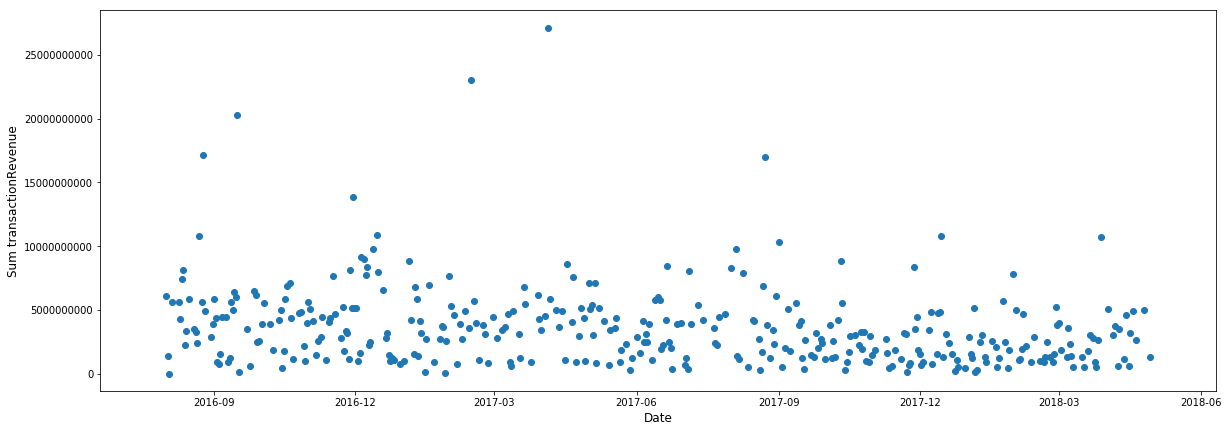

In [12]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Sum transactionRevenue', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

Seems we had more transactions on late 2016 and early 2017, date features seems to be a good addition to our model.

#### And here count of our target feature "transactionRevenue".

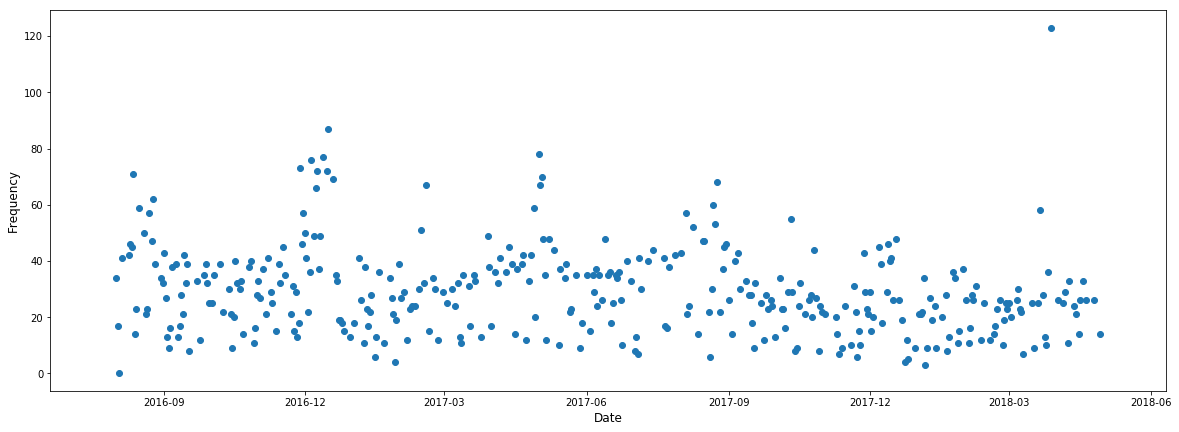

In [13]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

Again we had higher frequency at a similar time period.

#### Let's take a look at other time features.

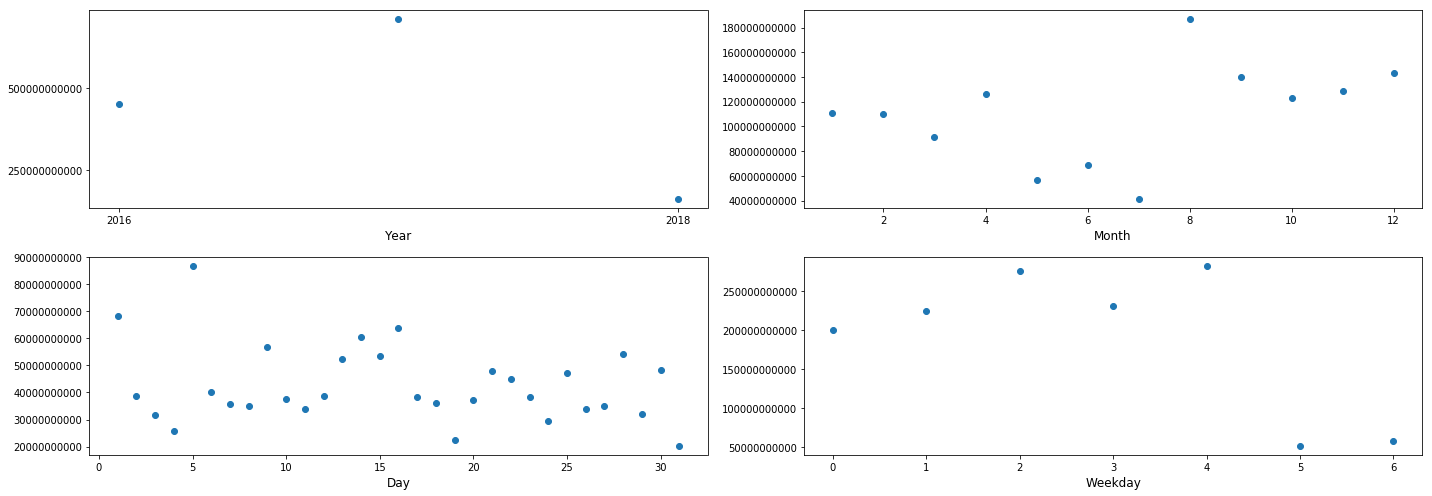

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
ax1.scatter(year_agg.index.values, year_agg['sum'])
ax1.locator_params(nbins=2)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xlabel('Year', fontsize=12)

ax2.scatter(month_agg.index.values, month_agg['sum'])
ax2.locator_params(nbins=12)
ax2.ticklabel_format(axis='y', style='plain')
ax2.set_xlabel('Month', fontsize=12)

ax3.scatter(day_agg.index.values, day_agg['sum'])
ax3.locator_params(nbins=10)
ax3.ticklabel_format(axis='y', style='plain')
ax3.set_xlabel('Day', fontsize=12)

ax4.scatter(weekday_agg.index.values, weekday_agg['sum'])
ax4.locator_params(nbins=7)
ax4.ticklabel_format(axis='y', style='plain')
ax4.set_xlabel('Weekday', fontsize=12)

plt.tight_layout()
plt.show()

### About the engineered time features
* Year: It seem transactions had a large increase from 2016 to 2017
* Month: Lager transaction on december seems ok, but about months but im not sure why high values on april and august (maybe because of easter (april) or Tax-free weekend, back-to-school season(august)?)
* Day: Here it seems that not really important is going on, seems this features can be discarded.
* Weekday: Something strange is going on here, seems that weekends have less transactions?

### The let's do some cleaning

In [15]:
# Drop column that exists only in train data
train = train.drop(['trafficSource.campaignCode'], axis=1)
# Input missing transactionRevenue values
train["totals.transactionRevenue"].fillna(0, inplace=True)

test_ids = test["fullVisitorId"].values

### Drop unwanted columns

In [16]:
# Unwanted columns
unwanted_columns = ['channelGrouping', 'customDimensions.index', 'customDimensions.value', 'fullVisitorId',
                   'visitId', 'visitNumber', 'visitStartTime',
                   'device.browser', 'device.browserSize', 'device.browserVersion',
                   'device.deviceCategory', 'device.flashVersion',
                   'device.language', 'device.mobileDeviceBranding',
                   'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
                   'device.mobileDeviceModel', 'device.mobileInputSelector',
                   'device.operatingSystem', 'device.operatingSystemVersion',
                   'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
                   'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
                   'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
                   'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
                   'geoNetwork.region', 'geoNetwork.subContinent',       
                   'totals.sessionQualityDim', 'trafficSource.adContent',
                   'trafficSource.adwordsClickInfo.adNetworkType',
                   'trafficSource.adwordsClickInfo.criteriaParameters',
                   'trafficSource.adwordsClickInfo.gclId',
                   'trafficSource.adwordsClickInfo.page',
                   'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
                   'trafficSource.isTrueDirect', 'trafficSource.keyword',
                   'trafficSource.medium', 'trafficSource.referralPath',
                   'trafficSource.source']

train = train.drop(unwanted_columns, axis=1)
test = test.drop(unwanted_columns, axis=1)
# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)
train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)
# Columns with more than 50% null data
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns more than 50% null values: ', high_null_columns)
train = train.drop(high_null_columns, axis=1)
test = test.drop(high_null_columns, axis=1)

Columns with constant values:  ['socialEngagementType', 'totals.bounces', 'totals.newVisits', 'totals.visits', 'trafficSource.adwordsClickInfo.isVideoAd']
Columns more than 50% null values:  ['totals.timeOnSite', 'totals.totalTransactionRevenue', 'totals.transactions']


### This is our new data with some cleaning and engineering.

In [17]:
print('TRAIN SET')
print('Rows: %s' % train.shape[0])
print('Columns: %s' % train.shape[1])
print('Features: %s' % train.columns.values)

print()
print('TEST SET')
print('Rows: %s' % test.shape[0])
print('Columns: %s' % test.shape[1])
print('Features: %s' % test.columns.values)

TRAIN SET
Rows: 1000000
Columns: 13
Features: ['date' 'device.isMobile' 'totals.hits' 'totals.pageviews'
 'totals.transactionRevenue' 'year' 'month' 'day' 'weekday'
 'mean_hits_per_day' 'mean_pageviews_per_day' 'sum_hits_per_day'
 'sum_pageviews_per_day']

TEST SET
Rows: 401589
Columns: 13
Features: ['date' 'device.isMobile' 'totals.hits' 'totals.pageviews'
 'totals.transactionRevenue' 'year' 'month' 'day' 'weekday'
 'mean_hits_per_day' 'mean_pageviews_per_day' 'sum_hits_per_day'
 'sum_pageviews_per_day']


In [18]:
train.head()

,date,device.isMobile,totals.hits,totals.pageviews,totals.transactionRevenue,year,month,day,weekday,mean_hits_per_day,mean_pageviews_per_day,sum_hits_per_day,sum_pageviews_per_day
0,2017-10-16,False,1.0,1.0,0.0,2017,10,16,0,4.258177,3.591892,115222.0,97193.0
1,2017-10-16,False,2.0,2.0,0.0,2017,10,16,0,58.785714,46.428571,2469.0,1950.0
2868,2017-10-16,False,2.0,2.0,0.0,2017,10,16,0,58.785714,46.428571,2469.0,1950.0
7755,2017-11-30,False,3.0,3.0,0.0,2017,11,30,3,58.785714,46.428571,2469.0,1950.0
422426,2017-09-22,False,2.0,2.0,0.0,2017,9,22,4,58.785714,46.428571,2469.0,1950.0


### One-hot encode categorical data

In [19]:
categorical_features = ['device.isMobile','year', 'month', 'weekday', 'day']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

In [20]:
# align both data sets (by outer join), to make they have the same amount of features,
# this is required because of the mismatched categorical values in train and test sets
train, test = train.align(test, join='outer', axis=1)

# replace the nan values added by align for 0
train.replace(to_replace=np.nan, value=0, inplace=True)
test.replace(to_replace=np.nan, value=0, inplace=True)

### Split data in train and validation by date

In [21]:
X_train = train[train['date']<=datetime.date(2017, 5, 31)]
X_val = train[train['date']>datetime.date(2017, 5, 31)]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [22]:
# Get labels
Y_train = X_train['totals.transactionRevenue'].values
Y_val = X_val['totals.transactionRevenue'].values
X_train = X_train.drop(['totals.transactionRevenue'], axis=1)
X_val = X_val.drop(['totals.transactionRevenue'], axis=1)
test = test.drop(['totals.transactionRevenue'], axis=1)
# Log transform the labels
Y_train = np.log1p(Y_train)
Y_val = np.log1p(Y_val)

In [23]:
reduce_features = ['date']
X_train = X_train.drop(reduce_features, axis=1)
X_val = X_val.drop(reduce_features, axis=1)
test = test.drop(reduce_features, axis=1)

In [24]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
test = test.astype('float32')

In [25]:
X_train.head()

,day_1,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,device.isMobile_False,device.isMobile_True,mean_hits_per_day,mean_pageviews_per_day,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,sum_hits_per_day,sum_pageviews_per_day,totals.hits,totals.pageviews,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,year_2016,year_2017,year_2018
953880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.746479,35.140846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3106.0,2495.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
537013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.255245,21.811190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7795.0,6238.0,6.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
390910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,48.000000,43.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,288.0,258.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
205486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,122.000000,92.599998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1220.0,926.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
293075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,122.000000,92.599998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1220.0,926.0,6.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Model
* Now let's to use the famous LGBM to model our data.

In [26]:
params = {
"objective" : "regression",
"metric" : "rmse", 
"num_leaves" : 500,
"min_child_samples" : 20,
"learning_rate" : 0.005,
"bagging_fraction" : 0.6,
"feature_fraction" : 0.7,
"bagging_frequency" : 1,
"bagging_seed" : 1,
"lambda_l1": 3,
'min_data_in_leaf': 70
}

In [27]:
lgb_train = lgb.Dataset(X_train, label=Y_train)
lgb_val = lgb.Dataset(X_val, label=Y_val)
model = lgb.train(params, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.82448	valid_1's rmse: 1.59422
[200]	training's rmse: 1.73692	valid_1's rmse: 1.55436
[300]	training's rmse: 1.6884	valid_1's rmse: 1.54048
[400]	training's rmse: 1.65735	valid_1's rmse: 1.53705
[500]	training's rmse: 1.63332	valid_1's rmse: 1.53757
Early stopping, best iteration is:
[431]	training's rmse: 1.64966	valid_1's rmse: 1.53682


### Let's have a look at the our model prediction on the validation set against the labels.
* Each point is a value from the data (axis x = label, axis y = prediction).
* The dashed line would be the perfect values (prediction = labels).
* The continuous line would be a linear regression.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


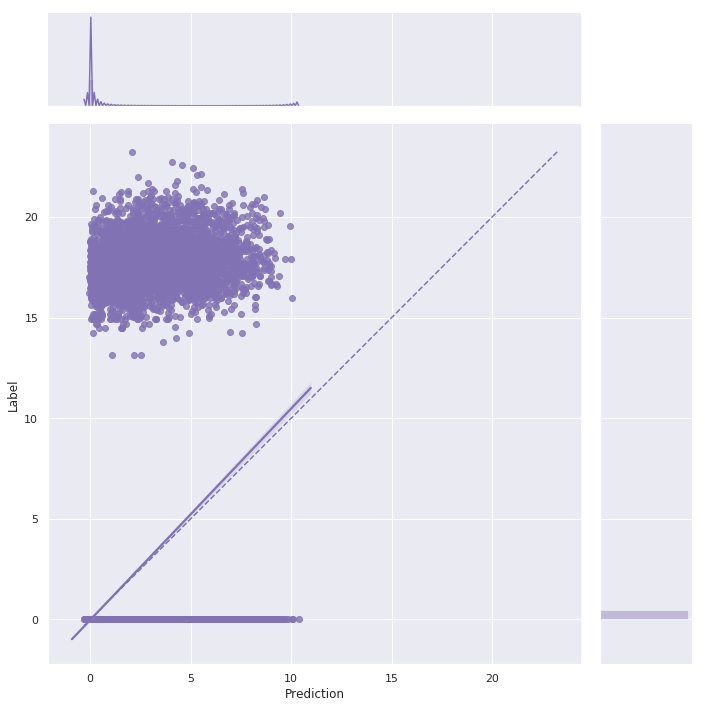

In [28]:
# Make prediction on validation data.
val_predictions = model.predict(X_val, num_iteration=model.best_iteration)
# Get min and max values of the predictions and labels.
min_val = max(max(val_predictions), max(Y_val))
max_val = min(min(val_predictions), min(Y_val))
# Create dataframe with validation predicitons and labels.
val_df = pd.DataFrame({"Label":Y_val})
val_df["Prediction"] = val_predictions
# Plot data
sns.set(style="darkgrid")
sns.jointplot(y="Label", x="Prediction", data=val_df, kind="reg", color="m", height=10)
plt.plot([min_val, max_val], [min_val, max_val], 'm--')
plt.show()

### Model metrics

In [29]:
val_predictions[val_predictions<0] = 0
mse = mean_squared_error(val_predictions, Y_val)
rmse = np.sqrt(mean_squared_error(val_predictions, Y_val))

print('Model validation metrics')
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)

Model validation metrics
MSE: 2.36
RMSE: 1.54


### Feature importance

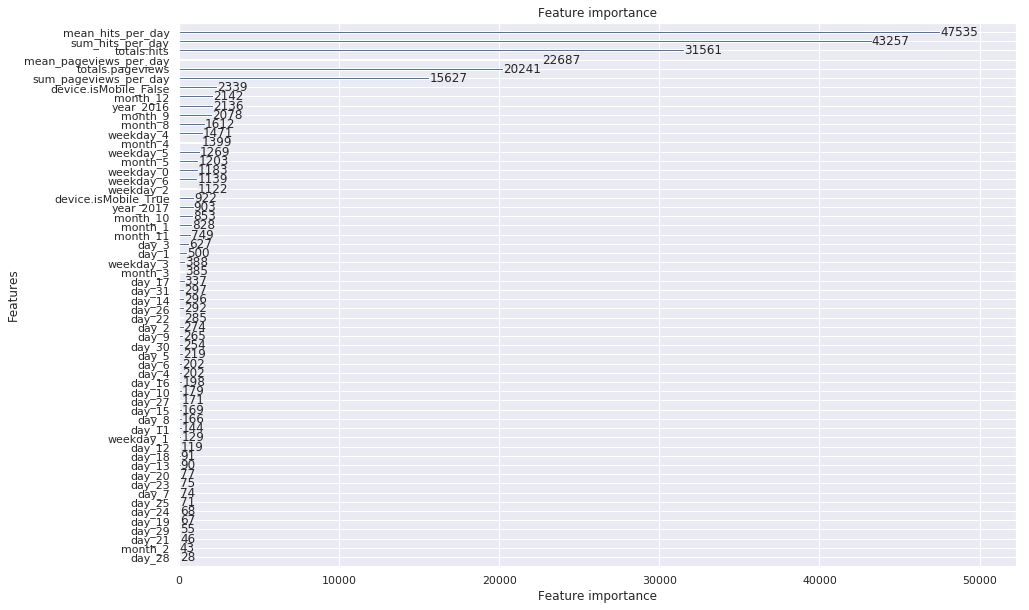

In [30]:
lgb.plot_importance(model, figsize=(15, 10))
plt.show()

In [31]:
predictions = model.predict(test, num_iteration=model.best_iteration)

submission = pd.DataFrame({"fullVisitorId":test_ids})
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.to_csv("submission.csv", index=False)
submission.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.081787
1,0000039738481224681,0.035151
2,0000073585230191399,0.027077
3,0000087588448856385,0.096064
4,0000149787903119437,0.040429
5,0000196310838896290,0.562966
6,00001995526696366,0.036048
7,0000255704530917106,4.653139
8,0000268499301061358,0.116636
9,0000276747989270229,0.061818
